In [2]:
import glob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import LeaveOneOut, cross_val_score
import sklearn.cross_validation as cv

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#ls

In [3]:
#dateparse = lambda x: pd.datetime.strptime(x, '%y/%m/%d %H:%M')

countries = pd.read_csv('../../Kaggle/Airbnb/countries.csv')
age = pd.read_csv('../../Kaggle/Airbnb/age_gender_bkts.csv')
test = pd.read_csv('../../Kaggle/Airbnb/test_users.csv', \
                         parse_dates=['date_account_created', 'timestamp_first_active', 'date_first_booking'])
sample = pd.read_csv('../../Kaggle/Airbnb/sample_submission_NDF.csv')
sessions = pd.read_csv('../../Kaggle/Airbnb/sessions.csv')
train = pd.read_csv('../../Kaggle/Airbnb/train_users_2.csv', nrows=150000,\
                            parse_dates=['date_account_created', 'timestamp_first_active', 'date_first_booking'])



In [5]:
#print(age_gender_bkts.shape)
#print(age_gender_bkts.head())
#print(test_users.head())
#test_users.shape
#print(sample_submission_NDF.head())
#sample_submission_NDF.shape
#print(sessions.head())
#sessions[sessions['user_id'] == 'd1mm9tcy42']
#print(train_users_2.shape)
#print(train_users_2.head())
#print(train_users_2['gender'].unique())
#print(train_users_2['gender'].value_counts())
#print(train_users_2['age'].value_counts())
#train_users_2[train_users_2['age'] == 2014]
#allusers = pd.concat((train_users_2, test_users), axis=0, ignore_index=True)

In [6]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
train['dac_dayofweek'] = [i.dayofweek for i in train['date_account_created']]
train['dac_day'] = [i.dayofyear for i in train['date_account_created']]
train['dac_month'] = [i.month for i in train['date_account_created']]
train['dac_year'] = [i.year for i in train['date_account_created']]
train['tfa_dayofweek'] = [i.dayofweek for i in train['timestamp_first_active']]
train['tfa_day'] = [i.dayofyear for i in train['timestamp_first_active']]
train['tfa_month'] = [i.month for i in train['timestamp_first_active']]
train['tfa_year'] = [i.year for i in train['timestamp_first_active']]
train['tfa_hour'] = [i.hour for i in train['timestamp_first_active']]
train['dfb_dayofweek'] = [i.dayofweek for i in train['date_first_booking']]
train['dfb_day'] = [i.dayofyear for i in train['date_first_booking']]
train['dfb_month'] = [i.month for i in train['date_first_booking']]
train['dfb_year'] = [i.year for i in train['date_first_booking']]

In [8]:
print(pd.unique(train['gender']))
gd = pd.get_dummies(train['gender'])
train = train.merge(gd, suffixes=('', ''),
                            left_index=True, right_index=True)

['-unknown-' 'MALE' 'FEMALE' 'OTHER']


In [9]:
train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,tfa_year,tfa_hour,dfb_dayofweek,dfb_day,dfb_month,dfb_year,-unknown-,FEMALE,MALE,OTHER
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,...,2009,4,NaN,NaN,NaN,NaN,1,0,0,0
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38,facebook,0,en,seo,...,2009,17,NaN,NaN,NaN,NaN,0,0,1,0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,...,2009,23,0,214,8,2010,0,1,0,0
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,...,2009,6,5,252,9,2012,0,1,0,0
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,...,2009,6,3,49,2,2010,1,0,0,0
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,2010-01-02,-unknown-,NaN,basic,0,en,other,...,2010,21,5,2,1,2010,1,0,0,0
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,...,2010,1,1,5,1,2010,0,1,0,0
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47,basic,0,en,direct,...,2010,19,2,13,1,2010,0,1,0,0
8,a1vcnhxeij,2010-01-04,2010-01-04 00:42:11,2010-07-29,FEMALE,50,basic,0,en,other,...,2010,0,3,210,7,2010,0,1,0,0
9,6uh8zyj2gn,2010-01-04,2010-01-04 02:37:58,2010-01-04,-unknown-,46,basic,0,en,other,...,2010,2,0,4,1,2010,1,0,0,0


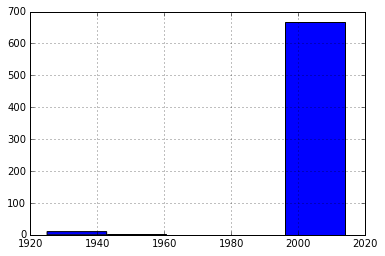

In [10]:
train[train.age > 1000].age.hist(bins=5)

In [11]:
train['age'] = train['age'].apply(lambda x: (2016 - x) if x > 1916 else x)

In [12]:
train[train['age'] > 97] = np.NaN
train[train['age'] < 15] = np.NaN

In [13]:
train['age'].mean()

37.08210390550754

In [14]:
train['age'] = train['age'].fillna(train['age'].mean())

In [15]:
train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,tfa_year,tfa_hour,dfb_dayofweek,dfb_day,dfb_month,dfb_year,-unknown-,FEMALE,MALE,OTHER
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,37.082104,facebook,0,en,direct,...,2009,4,NaN,NaN,NaN,NaN,1,0,0,0
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.000000,facebook,0,en,seo,...,2009,17,NaN,NaN,NaN,NaN,0,0,1,0
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.000000,basic,3,en,direct,...,2009,23,0,214,8,2010,0,1,0,0
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.000000,facebook,0,en,direct,...,2009,6,5,252,9,2012,0,1,0,0
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.000000,basic,0,en,direct,...,2009,6,3,49,2,2010,1,0,0,0
5,osr2jwljor,2010-01-01,2010-01-01 21:56:19,2010-01-02,-unknown-,37.082104,basic,0,en,other,...,2010,21,5,2,1,2010,1,0,0,0
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46.000000,basic,0,en,other,...,2010,1,1,5,1,2010,0,1,0,0
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47.000000,basic,0,en,direct,...,2010,19,2,13,1,2010,0,1,0,0
8,a1vcnhxeij,2010-01-04,2010-01-04 00:42:11,2010-07-29,FEMALE,50.000000,basic,0,en,other,...,2010,0,3,210,7,2010,0,1,0,0
9,6uh8zyj2gn,2010-01-04,2010-01-04 02:37:58,2010-01-04,-unknown-,46.000000,basic,0,en,other,...,2010,2,0,4,1,2010,1,0,0,0


In [16]:
train.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'dac_dayofweek', 'dac_day',
       'dac_month', 'dac_year', 'tfa_dayofweek', 'tfa_day', 'tfa_month',
       'tfa_year', 'tfa_hour', 'dfb_dayofweek', 'dfb_day', 'dfb_month',
       'dfb_year', '-unknown-', 'FEMALE', 'MALE', 'OTHER'],
      dtype='object')

In [17]:
print(pd.unique(train['signup_method']))
sm = pd.get_dummies(train['signup_method'])
train = train.merge(sm, suffixes=('train', ''),
                            left_index=True, right_index=True)

['facebook' 'basic' nan]


In [18]:
print(pd.unique(train['language']))
lang = pd.get_dummies(train['language'])
train = train.merge(lang, suffixes=('train', ''),
                            left_index=True, right_index=True)

['en' 'fr' nan 'de' 'es' 'it' 'zh' 'ko' 'ja' 'ru' 'pl' 'el' 'sv' 'pt' 'nl'
 'hu' 'da' 'id' 'fi' 'no' 'tr' 'th' 'cs' 'hr' 'ca' 'is']


In [19]:
print(pd.unique(train['affiliate_channel']))
ac = pd.get_dummies(train['affiliate_channel'])
train = train.merge(ac, suffixes=('', ''),
                            left_index=True, right_index=True)

['direct' 'seo' 'other' 'sem-non-brand' 'content' nan 'sem-brand'
 'remarketing' 'api']


In [20]:
print(pd.unique(train['affiliate_provider']))
ap = pd.get_dummies(train['affiliate_provider'])
train = train.merge(ap, suffixes=('train', ''),
                            left_index=True, right_index=True)

['direct' 'google' 'other' 'craigslist' 'facebook' nan 'vast' 'bing'
 'meetup' 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp'
 'wayn' 'naver' 'baidu' 'yandex']


In [21]:
print(pd.unique(train['first_affiliate_tracked']))
fat = pd.get_dummies(train['first_affiliate_tracked'])
train = train.merge(fat, suffixes=('', ''),
                            left_index=True, right_index=True)

['untracked' 'omg' nan 'linked' 'tracked-other' 'product' 'marketing'
 'local ops']


In [22]:
print(pd.unique(train['signup_app']))
sa = pd.get_dummies(train['signup_app'])
train = train.merge(sa, suffixes=('', ''),
                            left_index=True, right_index=True)

['Web' nan 'Moweb' 'iOS' 'Android']


In [23]:
print(pd.unique(train['first_device_type']))
fdt = pd.get_dummies(train['first_device_type'])
train = train.merge(fdt, suffixes=('', ''),
                            left_index=True, right_index=True)


['Mac Desktop' 'Windows Desktop' 'iPhone' 'Other/Unknown' 'Desktop (Other)'
 'Android Tablet' 'iPad' 'Android Phone' nan 'SmartPhone (Other)']


In [24]:
print(pd.unique(train['first_browser']))
train.first_browser = train.first_browser.str.replace('-unknown-', 'notknown')
print('-------')
print(pd.unique(train['first_browser']))
fb = pd.get_dummies(train['first_browser'])
train = train.merge(fb, suffixes=('train', ''),
                            left_index=True, right_index=True)

['Chrome' 'IE' 'Firefox' 'Safari' '-unknown-' 'Mobile Safari'
 'Chrome Mobile' nan 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Opera' 'TenFourFox' 'Mobile Firefox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Maxthon'
 'Kindle Browser' 'CoolNovo' 'Conkeror' 'wOSBrowser' 'Google Earth'
 'Crazy Browser' 'Mozilla' 'OmniWeb' 'PS Vita browser' 'NetNewsWire'
 'CometBird' 'Comodo Dragon' 'Flock' 'Pale Moon' 'Avant Browser'
 'Opera Mobile' 'Yandex.Browser' 'TheWorld Browser' 'SlimBrowser' 'Epic'
 'Stainless']
-------
['Chrome' 'IE' 'Firefox' 'Safari' 'notknown' 'Mobile Safari'
 'Chrome Mobile' nan 'RockMelt' 'Chromium' 'Android Browser' 'AOL Explorer'
 'Palm Pre web browser' 'Opera' 'TenFourFox' 'Mobile Firefox' 'IE Mobile'
 'Apple Mail' 'Silk' 'Camino' 'Arora' 'BlackBerry Browser' 'SeaMonkey'
 'Iron' 'Sogou Explorer' 'IceWeasel' 'Opera Mini' 'SiteKiosk' 'Max

In [1]:
#We notice that not all of the train features are in test!!! - very important.

In [25]:
print(list(train.columns))

['idtrain', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'country_destination', 'dac_dayofweek', 'dac_day', 'dac_month', 'dac_year', 'tfa_dayofweek', 'tfa_day', 'tfa_month', 'tfa_year', 'tfa_hour', 'dfb_dayofweek', 'dfb_day', 'dfb_month', 'dfb_year', '-unknown-', 'FEMALE', 'MALE', 'OTHER', 'basic', 'facebooktrain', 'ca', 'cs', 'da', 'de', 'el', 'en', 'es', 'fi', 'fr', 'hr', 'hu', 'id', 'is', 'it', 'ja', 'ko', 'nl', 'no', 'pl', 'pt', 'ru', 'sv', 'th', 'tr', 'zh', 'api', 'content', 'directtrain', 'othertrain', 'remarketing', 'sem-brand', 'sem-non-brand', 'seo', 'baidu', 'bing', 'craigslist', 'direct', 'email-marketing', 'facebook', 'facebook-open-graph', 'google', 'gsp', 'meetup', 'naver', 'other', 'padmapper', 'vast', 'wayn', 'yahoo', 'yandex', 'linked', 'local ops', 'marketing', 

In [26]:
train.drop(labels=['idtrain'], axis=1, inplace=True)
train.drop(labels=['date_account_created'], axis=1, inplace=True)
train.drop(labels=['timestamp_first_active'], axis=1, inplace=True)
train.drop(labels=['date_first_booking'], axis=1, inplace=True)
train.drop(labels=['gender'], axis=1, inplace=True)
train.drop(labels=['signup_method'], axis=1, inplace=True)
train.drop(labels=['language'], axis=1, inplace=True)
train.drop(labels=['affiliate_channel'], axis=1, inplace=True)
train.drop(labels=['affiliate_provider'], axis=1, inplace=True)
train.drop(labels=['first_affiliate_tracked'], axis=1, inplace=True)
train.drop(labels=['signup_app'], axis=1, inplace=True)
train.drop(labels=['first_device_type'], axis=1, inplace=True)
train.drop(labels=['first_browser'], axis=1, inplace=True)

In [27]:
train['age'] = train['age'].apply(lambda x: int(x))

In [28]:
feature_cols = ['age', 'signup_flow', 'dac_dayofweek', 'dac_day', 'dac_month', 'dac_year', 'tfa_dayofweek', \
                'tfa_day', 'tfa_month', 'tfa_year', 'tfa_hour', '-unknown-', 'FEMALE', 'MALE', 'OTHER', 'basic', 'facebooktrain', \
                'ca', 'cs', 'da', 'de', 'el', 'en', 'es', 'fi', 'fr', 'hu', 'id', 'it', 'ja', 'ko', 'nl', \
                'no', 'pl', 'pt', 'ru', 'sv', 'th', 'tr', 'zh', 'content', 'directtrain', 'othertrain', \
                'remarketing', 'sem-brand', 'sem-non-brand', 'seo', 'baidu', 'bing', 'craigslist', 'direct', \
                'email-marketing', 'facebook', 'facebook-open-graph', 'google', 'gsp', 'meetup', 'naver', 'other', \
                'padmapper', 'vast', 'yahoo', 'yandex', 'linked', 'local ops', 'marketing', 'omg', 'product', \
                'tracked-other', 'untracked', 'Android', 'Moweb', 'Web', 'iOS', 'Android Phone', 'Android Tablet', \
                'Desktop (Other)', 'Mac Desktop', 'Other/Unknown', 'SmartPhone (Other)', 'Windows Desktop', 'iPad', \
                'iPhone', 'AOL Explorer', 'Android Browser', 'Apple Mail', \
                'BlackBerry Browser', 'Chrome', 'Chrome Mobile', 'Chromium', 'CometBird', 'Firefox', \
                'IE', 'IE Mobile', 'IceWeasel', 'Iron', 'Maxthon', 'Mobile Firefox', \
                'Mobile Safari', 'Opera', 'Opera Mini', 'Opera Mobile', \
                'Pale Moon', 'Safari', 'SeaMonkey', 'Silk', 'SiteKiosk', 'Sogou Explorer', \
                'Yandex.Browser', 'notknown', 'wOSBrowser']


X = train[feature_cols]
y = train['country_destination'].ravel()

print(X.shape, y.shape)

(150000, 111) (150000,)


In [29]:
y

array(['NDF', 'NDF', 'US', ..., 'NDF', 'other', 'NDF'], dtype=object)

In [30]:
le = preprocessing.LabelEncoder()
le = le.fit(list(y))
ylabel = le.fit_transform(list(y))
ylabel

array([ 7,  7, 10, ...,  7, 12,  7])

In [31]:
#X.isnull().sum()
X = X.fillna(0)

In [32]:
X.isnull().any().any()

False

In [33]:
#Random Forest Classifier

rfr = RandomForestClassifier()
rfr.fit(X, ylabel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
rfr.score(X, ylabel)

0.97039333333333333

In [35]:
y_pred = rfr.predict(X)
y_pred

array([ 7,  7, 10, ...,  7, 12,  7])

In [36]:
metrics.accuracy_score(ylabel, y_pred)
#Overfitting

0.97039333333333333

In [37]:
#le.inverse_transform(y_pred)

In [38]:
print(mean_squared_error(ylabel, y_pred)) 
#Little error, so it looks like we are overfitting.
#Therefore, we want to use a cross validation, train test split to get more accurate measure of actual error

0.38538


In [39]:
#pd.DataFrame({'ylabel': ylabel,'y_pred': y_pred, 'error': np.abs(ylabel - y_pred)})

In [40]:
#Random Forest, Cross Validation
print(cross_val_score(rfr, X, ylabel, cv = 3))
np.mean(cross_val_score(rfr, X, ylabel, cv = 3)) 

[ 0.06877312  0.2299692   0.57059424]


0.28576485519576295

In [41]:
#new_X = X.head(10000)
#new_ylabel = ylabel[10000]

In [42]:
#K-Nearest Neighbor Classifier

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X, ylabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [43]:
knn.predict(X)

array([ 7,  7, 10, ...,  7, 12,  7])

In [44]:
knn.score(X, ylabel)

0.99213333333333331

In [45]:
#Nearest Neighbor, Cross Validation
print(cross_val_score(knn, X, ylabel, cv = 3))
np.mean(cross_val_score(knn, X, ylabel, cv = 3))

[ 0.33894611  0.28881155  0.46902814]


0.36559526651335367

In [50]:
inv = list(le.inverse_transform(knn.predict(X)))
inv

['NDF',
 'NDF',
 'US',
 'other',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'US',
 'NDF',
 'FR',
 'NDF',
 'NDF',
 'CA',
 'NDF',
 'US',
 'NDF',
 'FR',
 'US',
 'US',
 'US',
 'NDF',
 'NDF',
 'FR',
 'NDF',
 'US',
 'FR',
 'US',
 'FR',
 'NDF',
 'NDF',
 'NDF',
 'NDF',
 'NDF',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'NDF',
 'US',
 'NDF',
 'NDF',
 'GB',
 'US',
 'ES',
 'US',
 'NDF',
 'US',
 'NDF',
 'US',
 'US',
 'NDF',
 'US',
 'US',
 'NDF',
 'CA',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'NDF',
 'CA',
 'CA',
 'NDF',
 'NDF',
 'US',
 'NDF',
 'NDF',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'FR',
 'US',
 'US',
 'NDF',
 'GB',
 'NDF',
 'other',
 'US',
 'NDF',
 'NDF',
 'US',
 'US',
 'US',
 'IT',
 'NDF',
 'NDF',
 'FR',
 'US',
 'FR',
 'US',
 'US',
 'US',
 'US',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'NDF',
 'ES',
 'NDF',
 'US',
 'US',
 'NDF',
 'FR',
 'NDF',
 'NDF',
 'CA',
 'US',
 'US',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'FR',
 'US',
 'NDF',
 'US',
 'US',
 'NDF',
 'NDF',
 'US',
 'NDF',
 'NDF',
 'NDF',
 'US',
 'other',
 'US',
 'IT',
 'NDF',


Feature ranking:
1. feature 10 (0.145877)
2. feature 0 (0.131167)
3. feature 3 (0.119880)
4. feature 7 (0.116218)
5. feature 2 (0.054617)
6. feature 6 (0.053894)
7. feature 8 (0.048042)
8. feature 4 (0.040612)
9. feature 5 (0.022510)
10. feature 9 (0.020472)
11. feature 1 (0.016908)
12. feature 11 (0.015084)
13. feature 15 (0.012625)
14. feature 87 (0.012187)
15. feature 69 (0.011319)
16. feature 91 (0.010955)
17. feature 63 (0.010172)
18. feature 13 (0.010001)
19. feature 80 (0.009123)
20. feature 77 (0.008386)
21. feature 12 (0.008349)
22. feature 103 (0.008280)
23. feature 16 (0.008099)
24. feature 66 (0.006891)
25. feature 54 (0.006162)
26. feature 92 (0.005924)
27. feature 41 (0.005198)
28. feature 45 (0.005070)
29. feature 44 (0.004885)
30. feature 50 (0.004363)
31. feature 22 (0.004203)
32. feature 98 (0.004096)
33. feature 81 (0.003905)
34. feature 72 (0.003507)
35. feature 68 (0.003437)
36. feature 109 (0.003363)
37. feature 46 (0.003322)
38. feature 40 (0.002997)
39. feature 

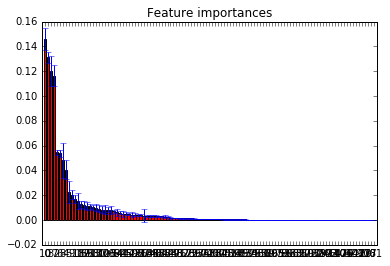

In [348]:
#Feature Ranking

rfr.fit(X, ylabel)
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [349]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Columns: 111 entries, age to wOSBrowser
dtypes: float64(110), int64(1)
memory usage: 128.2 MB


In [48]:
#list(X.columns)

In [47]:
#This will copy the knn and rfr functions, to be able to utilize it in a different notebook.

from sklearn.externals import joblib
joblib.dump(knn, 'airbnb-knn.pkl')

['airbnb-knn.pkl',
 'airbnb-knn.pkl_01.npy',
 'airbnb-knn.pkl_02.npy',
 'airbnb-knn.pkl_03.npy',
 'airbnb-knn.pkl_04.npy',
 'airbnb-knn.pkl_05.npy',
 'airbnb-knn.pkl_06.npy',
 'airbnb-knn.pkl_07.npy',
 'airbnb-knn.pkl_08.npy',
 'airbnb-knn.pkl_09.npy']

In [353]:
joblib.dump(rfr, 'airbnb-rfr.pkl')

['airbnb-rfr.pkl',
 'airbnb-rfr.pkl_01.npy',
 'airbnb-rfr.pkl_02.npy',
 'airbnb-rfr.pkl_03.npy',
 'airbnb-rfr.pkl_04.npy',
 'airbnb-rfr.pkl_05.npy',
 'airbnb-rfr.pkl_06.npy',
 'airbnb-rfr.pkl_07.npy',
 'airbnb-rfr.pkl_08.npy',
 'airbnb-rfr.pkl_09.npy',
 'airbnb-rfr.pkl_10.npy',
 'airbnb-rfr.pkl_11.npy',
 'airbnb-rfr.pkl_12.npy',
 'airbnb-rfr.pkl_13.npy',
 'airbnb-rfr.pkl_14.npy',
 'airbnb-rfr.pkl_15.npy',
 'airbnb-rfr.pkl_16.npy',
 'airbnb-rfr.pkl_17.npy',
 'airbnb-rfr.pkl_18.npy',
 'airbnb-rfr.pkl_19.npy',
 'airbnb-rfr.pkl_20.npy',
 'airbnb-rfr.pkl_21.npy',
 'airbnb-rfr.pkl_22.npy',
 'airbnb-rfr.pkl_23.npy',
 'airbnb-rfr.pkl_24.npy',
 'airbnb-rfr.pkl_25.npy',
 'airbnb-rfr.pkl_26.npy',
 'airbnb-rfr.pkl_27.npy',
 'airbnb-rfr.pkl_28.npy',
 'airbnb-rfr.pkl_29.npy',
 'airbnb-rfr.pkl_30.npy',
 'airbnb-rfr.pkl_31.npy',
 'airbnb-rfr.pkl_32.npy',
 'airbnb-rfr.pkl_33.npy',
 'airbnb-rfr.pkl_34.npy',
 'airbnb-rfr.pkl_35.npy',
 'airbnb-rfr.pkl_36.npy',
 'airbnb-rfr.pkl_37.npy',
 'airbnb-rfr.pkl_38

In [51]:
joblib.dump(inv, 'airbnb-inv.pkl')

['airbnb-inv.pkl']

In [52]:
joblib.dump(le, 'airbnb-le.pkl')

['airbnb-le.pkl', 'airbnb-le.pkl_01.npy']

In [354]:
X.shape

(150000, 111)

In [10]:
countries.head(20)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


In [8]:
age.head(20)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


In [51]:
#logistic - multivariate logistic classification

In [52]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Columns: 146 entries, age to wOSBrowser
dtypes: float64(144), int64(1), object(1)
memory usage: 239.4+ MB


In [78]:
sample.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


In [287]:
list(test.columns)

['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']

In [286]:
list(train.columns)

['age',
 'signup_flow',
 'country_destination',
 'dac_dayofweek',
 'dac_day',
 'dac_month',
 'dac_year',
 'tfa_dayofweek',
 'tfa_day',
 'tfa_month',
 'tfa_year',
 'tfa_hour',
 'dfb_dayofweek',
 'dfb_day',
 'dfb_month',
 'dfb_year',
 '-unknown-train',
 'FEMALE',
 'MALE',
 'OTHER',
 'basic',
 'facebooktrain',
 'ca',
 'cs',
 'da',
 'de',
 'el',
 'en',
 'es',
 'fi',
 'fr',
 'hr',
 'hu',
 'id',
 'is',
 'it',
 'ja',
 'ko',
 'nl',
 'no',
 'pl',
 'pt',
 'ru',
 'sv',
 'th',
 'tr',
 'zh',
 'api',
 'content',
 'directtrain',
 'othertrain',
 'remarketing',
 'sem-brand',
 'sem-non-brand',
 'seo',
 'baidu',
 'bing',
 'craigslist',
 'direct',
 'email-marketing',
 'facebook',
 'facebook-open-graph',
 'google',
 'gsp',
 'meetup',
 'naver',
 'other',
 'padmapper',
 'vast',
 'wayn',
 'yahoo',
 'yandex',
 'linked',
 'local ops',
 'marketing',
 'omg',
 'product',
 'tracked-other',
 'untracked',
 'Android',
 'Moweb',
 'Web',
 'iOS',
 'Android Phone',
 'Android Tablet',
 'Desktop (Other)',
 'Mac Desktop',
 '

In [ ]:
age.head()

In [ ]:
sessions.head()

In [ ]:
train.info()

In [ ]:
train.info()

In [92]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


In [83]:
age.head(100)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015
5,75-79,AU,male,298,2015
6,70-74,AU,male,415,2015
7,65-69,AU,male,574,2015
8,60-64,AU,male,636,2015
9,55-59,AU,male,714,2015


In [ ]:
sample.head()

In [ ]:
sessions.head()

In [ ]:
train.gender.value_counts()

In [ ]:
sessions.device_type.value_counts()

In [ ]:
train.signup_method.value_counts()

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
import seaborn as sns
train.gender.value_counts(dropna=False).plot(kind='bar', color='b', rot=0)
plt.xlabel('Gender')
sns.despine()